# Deep Learning and Generative models



##  **Part 1 : Transfer Learning**

### 1. 1. Loading Packages


In [2]:
# Import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')


### 1. 2. Load and Explore Data

In [3]:
!wget -O data.zip https://www.dropbox.com/scl/fi/x9wbnxox44rey6xym4un7/data.zip?rlkey=uo2pos87olc6zgkdhp5dcverb&raw=1
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [ ]:
train_path = "chest_xray/train"
test_path = "chest_xray/test"
val_path = "chest_xray/val"

def get_class_distribution(path):
    normal_count = len(os.listdir(os.path.join(path, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(path, "PNEUMONIA")))
    return {"NORMAL": normal_count, "PNEUMONIA": pneumonia_count}

print("Train set class distribution:", get_class_distribution(train_path))
print("Test set class distribution:", get_class_distribution(test_path))
print("Validation set class distribution:", get_class_distribution(val_path))

#### 1. 2. 2. Now create a function to load data to Python.



In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),                # Resize to fixed dimensions
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Duplicate channel to simulate RGB
])

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

print("Class-to-index mapping:", train_dataset.class_to_idx)

 #### 1. 2. 3. show the class distributions (0 denotes a normal image, while 1 denotes an image depicting pneumonia) in train and test.


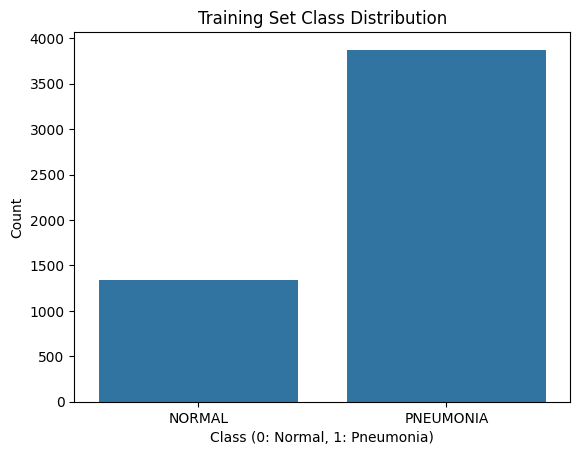

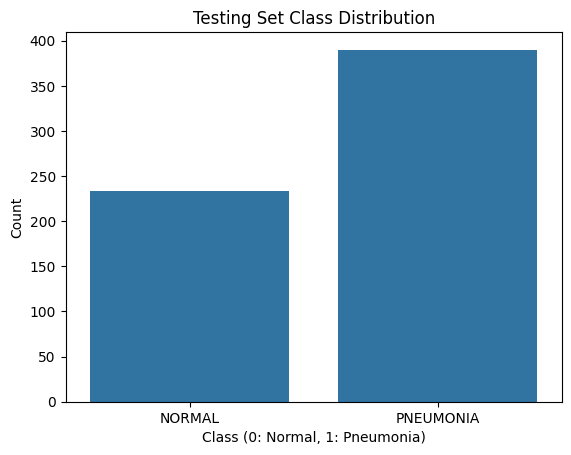

In [ ]:
from collections import Counter

def plot_class_distribution(dataset, title):
    labels = [label for _, label in dataset.samples]
    counts = Counter(labels)
    sns.barplot(x=['NORMAL', 'PNEUMONIA'], y=[counts[0], counts[1]])
    plt.title(title)
    plt.xlabel("Class (0: Normal, 1: Pneumonia)")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")
plot_class_distribution(test_dataset, "Testing Set Class Distribution")

 #### 1. 2. 4. Write a function to show arbitray number of normal or pneumonia images.
 

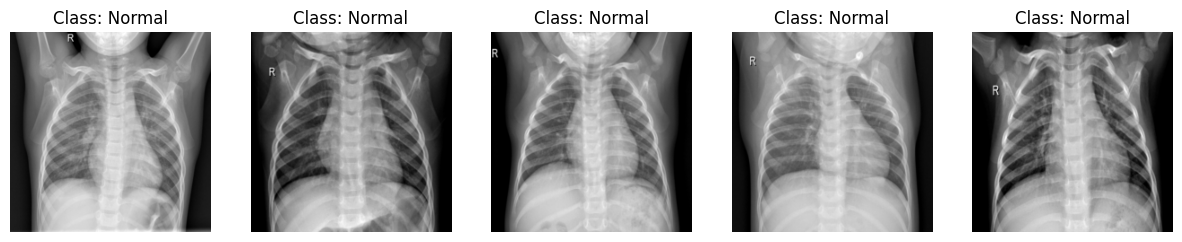

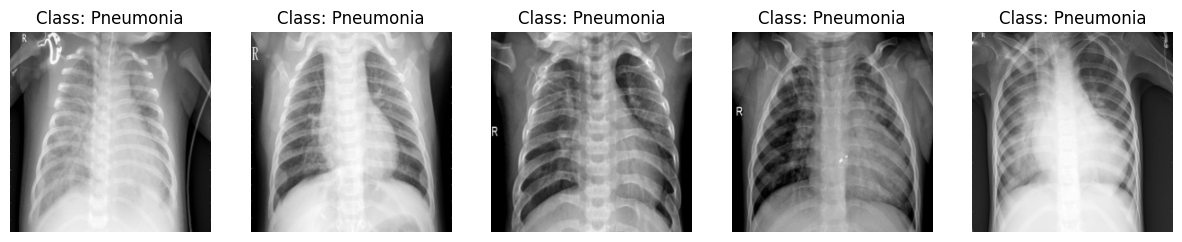

In [ ]:
def show_sample_images(dataset, class_label, count=5):
    plt.figure(figsize=(15, 5))
    class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_label][:count]
    for i, idx in enumerate(class_indices):
        img, _ = dataset[idx]
        img = img[0, :, :]  # Selecting the first channel for grayscale visualization
        plt.subplot(1, count, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title("Class: " + ("Normal" if class_label == 0 else "Pneumonia"))
        plt.axis("off")
    plt.show()

show_sample_images(train_dataset, class_label=0)  # normal images
show_sample_images(train_dataset, class_label=1)  # pneumonia images

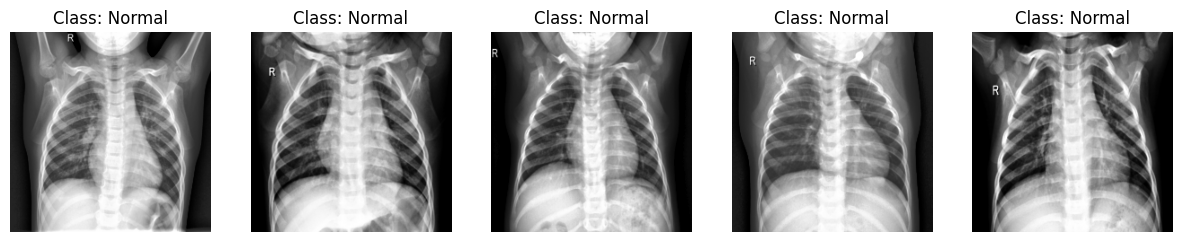

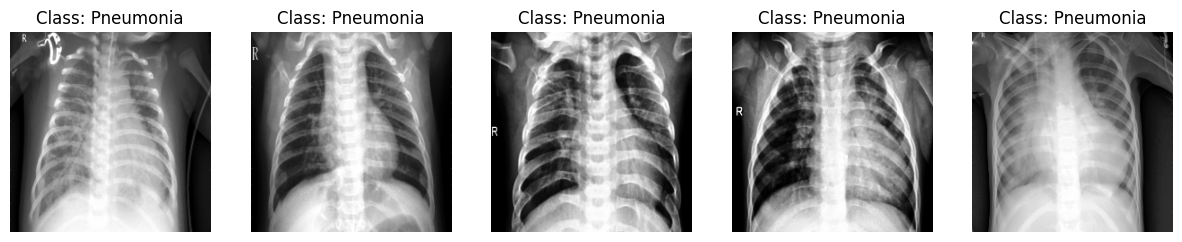

In [ ]:
import copy

def equalize_histogram(image):
    img_np = image.squeeze(0).numpy()  # Convert tensor to NumPy for processing
    img_np = img_np[0, :, :]  # Take the first channel in case it's an RGB-like image

    # Ensure values are in range [0, 255] for OpenCV
    img_np = (img_np * 255).astype(np.uint8)

    # Perform histogram equalization
    equalized_img = cv2.equalizeHist(img_np)

    # Normalize the image back to [0, 1] and convert to tensor
    return torch.tensor(equalized_img / 255.0).unsqueeze(0)  # Add channel dimension back

eq_train_dataset = copy.deepcopy(train_dataset)
eq_val_dataset = copy.deepcopy(val_dataset)
eq_test_dataset = copy.deepcopy(test_dataset)

eq_train_dataset.samples = [(equalize_histogram(img), label) for img, label in train_dataset]
eq_val_dataset.samples = [(equalize_histogram(img), label) for img, label in val_dataset]
eq_test_dataset.samples = [(equalize_histogram(img), label) for img, label in test_dataset]

def visualize_images_by_class(dataset, class_label, count=5):
    plt.figure(figsize=(15, 5))
    displayed = 0

    for i, (img, label) in enumerate(dataset):
        if label == class_label and displayed < count:
            img_np = img.squeeze(0).numpy()  # Convert tensor to NumPy array
            plt.subplot(1, count, displayed + 1)
            plt.imshow(img_np, cmap="gray")
            plt.title(f"Class: {'Normal' if class_label == 0 else 'Pneumonia'}")
            plt.axis("off")
            displayed += 1
        if displayed >= count:
            break

    plt.show()


visualize_images_by_class(eq_train_dataset.samples, class_label=0, count=5)
visualize_images_by_class(eq_train_dataset.samples, class_label=1, count=5)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path_base = "./chest_xray"
image_size=(224, 224)
batch_size=32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation and test generators (no augmentation, only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    directory=f"{path_base}/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    directory=f"{path_base}/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    directory=f"{path_base}/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### 2. 1. Build a Vanilla CNN Model


First step, arrange the data in different constructs (x_train, y_train, x_test, y_test, x_val,y_val), etc...):


In [ ]:
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

# Extracting data from train generator
for i in range(len(train_generator)):
    imgs, labels = next(train_generator)
    x_train.extend(imgs)
    y_train.extend(labels)

# Extracting data from validation generator
for i in range(len(val_generator)):
    imgs, labels = next(val_generator)
    x_val.extend(imgs)
    y_val.extend(labels)

# Extracting data from test generator
for i in range(len(test_generator)):
    imgs, labels = next(test_generator)
    x_test.extend(imgs)
    y_test.extend(labels)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"Train data shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: (5216, 224, 224, 3), Train labels shape: (5216,)
Validation data shape: (16, 224, 224, 3), Validation labels shape: (16,)
Test data shape: (624, 224, 224, 3), Test labels shape: (624,)


#### 2. 1.1. CNN Model
defines a CNN model with more than 18 layer.




In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # First Convolutional Layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Second Convolutional Layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Third Convolutional Layer
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  # Fourth Convolutional Layer
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  # Fifth Convolutional Layer

        # Batch Normalization Layers
        self.bn1 = nn.BatchNorm2d(64)   # BatchNorm for Conv1
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm for Conv2
        self.bn3 = nn.BatchNorm2d(256)  # BatchNorm for Conv3
        self.bn4 = nn.BatchNorm2d(512)  # BatchNorm for Conv4
        self.bn5 = nn.BatchNorm2d(512)  # BatchNorm for Conv5

        # Dropout Layers for Convolutional Blocks
        self.dropout1 = nn.Dropout2d(p=0.4)  # Dropout after Conv1
        self.dropout2 = nn.Dropout2d(p=0.4)  # Dropout after Conv2
        self.dropout3 = nn.Dropout2d(p=0.4)  # Dropout after Conv3
        self.dropout4 = nn.Dropout2d(p=0.5)  # Dropout after Conv4
        self.dropout5 = nn.Dropout2d(p=0.5)  # Dropout after Conv5

        # Pooling Layers
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool after Conv1
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool after Conv2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool after Conv3
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool after Conv4
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool after Conv5

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  # First Fully Connected Layer
        self.dropout_fc1 = nn.Dropout(p=0.5)    # Dropout after FC1

        self.fc2 = nn.Linear(1024, 512)         # Second Fully Connected Layer
        self.dropout_fc2 = nn.Dropout(p=0.5)    # Dropout after FC2

        self.fc3 = nn.Linear(512, 2)            # Output Layer for 2 classes (NORMAL vs PNEUMONIA)


    def forward(self, x):

        x = self.pool1(self.dropout1(F.relu(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(F.relu(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(F.relu(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(F.relu(self.bn4(self.conv4(x)))))
        x = self.pool5(self.dropout5(F.relu(self.bn5(self.conv5(x)))))

        # Flattening
        x = x.view(-1, 512 * 7 * 7)

        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.dropout_fc2(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyCNN().to(device)
print(model)

MyCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.4, inplace=False)
  (dropout2): Dropout2d(p=0.4, inplace=False)
  (dropout3): Dropout2d(p=0.4, inplace=False)
  (dropout4): D

#### 2. 1.2. Running The Model

Beafore runing the model use must fix the Imbalance Problem. please write a good solution and apply it to the Data.

10 Points

Addressing Class Imbalance Using Weighted Sampling:

Class imbalance occurs when the number of samples in one class significantly outweighs the number in the other. In this dataset, the "PNEUMONIA" class is much more frequent than the "NORMAL" class. Training a model directly on such data can lead to biased predictions, where the model favors the majority class. To address this, Weighted Sampling is employed.

Weighted Sampling:

Weighted Sampling ensures that each sample in the dataset is considered based on its class frequency. By assigning higher weights to samples from the minority class, the model is exposed to a more balanced representation of both classes during training.


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import transforms


def balance_dataloader(dataset, batch_size=32):
    # Extract labels from the dataset using samples attribute
    labels = [label for _, label in dataset.samples]
    labels = np.array(labels)

    # Calculate class counts and weights
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]  # Assign weights based on labels

    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoader with the sampler
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    return dataloader

train_dataloader = balance_dataloader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

    return train_losses, val_losses

model = MyCNN().to(device)
train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, num_epochs=5)

Epoch 1/5, Train Loss: 0.6767, Train Acc: 0.8138, Val Loss: 0.6051, Val Acc: 0.5000
Epoch 2/5, Train Loss: 0.3189, Train Acc: 0.8786, Val Loss: 0.4497, Val Acc: 0.6250
Epoch 3/5, Train Loss: 0.2115, Train Acc: 0.9225, Val Loss: 0.2603, Val Acc: 0.9375
Epoch 4/5, Train Loss: 0.1891, Train Acc: 0.9327, Val Loss: 0.4624, Val Acc: 0.7500
Epoch 5/5, Train Loss: 0.1577, Train Acc: 0.9410, Val Loss: 0.2327, Val Acc: 0.8750


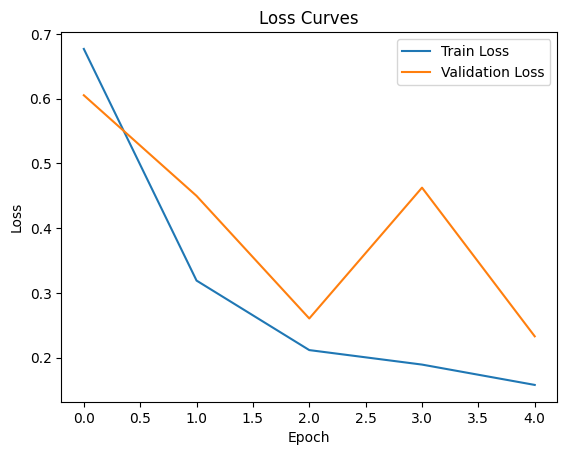

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

Accuracy on the test set: 82.37179487179488%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.56      0.71       234
     Class 1       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



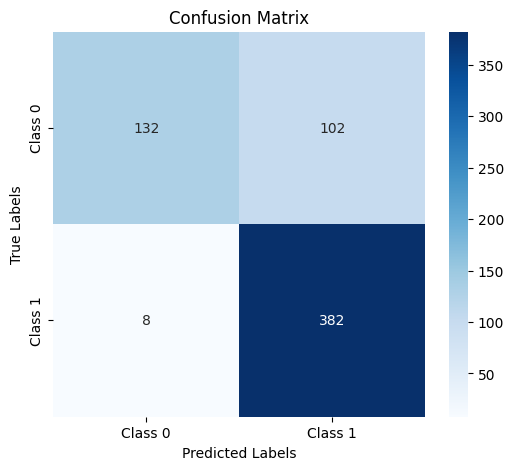

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, device):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * (np.array(all_predictions) == np.array(all_labels)).sum() / len(all_labels)
    print(f'Accuracy on the test set: {accuracy}%')

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1']))

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

evaluate_model(model, test_dataloader, device)

### 3.1. Transfer Learning


In [ ]:
pretrained_model = models.resnet50(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 2)
pretrained_model = pretrained_model.to(device)

train_losses, val_losses = train_model(pretrained_model, train_dataloader, val_dataloader, num_epochs=5)

Epoch 1/5, Train Loss: 0.1511, Train Acc: 0.9431, Val Loss: 4.3317, Val Acc: 0.5000
Epoch 2/5, Train Loss: 0.0898, Train Acc: 0.9691, Val Loss: 0.7258, Val Acc: 0.6250
Epoch 3/5, Train Loss: 0.0565, Train Acc: 0.9812, Val Loss: 0.9966, Val Acc: 0.5625
Epoch 4/5, Train Loss: 0.0710, Train Acc: 0.9734, Val Loss: 1.6235, Val Acc: 0.6250
Epoch 5/5, Train Loss: 0.0504, Train Acc: 0.9801, Val Loss: 0.1541, Val Acc: 0.9375


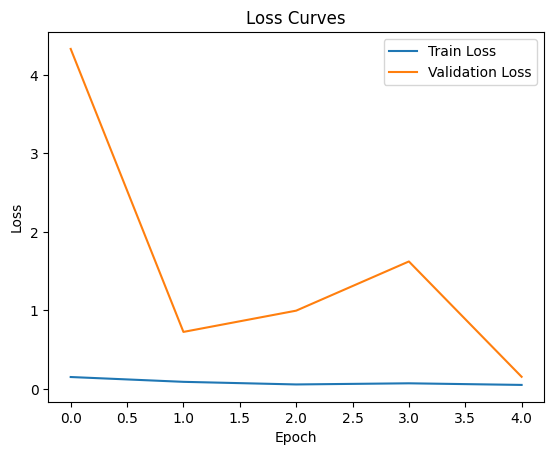

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

#### 3.1.2. show the confusion matrix for test data.



Accuracy on the test set: 84.13461538461539%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.62      0.75       234
     Class 1       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624



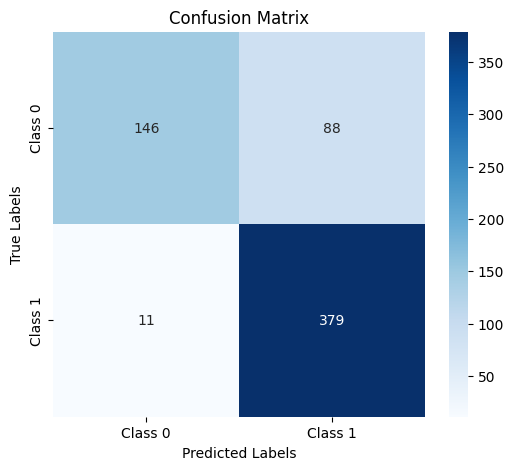

In [ ]:
evaluate_model(pretrained_model, test_dataloader, device)

### 4.1. Fine-tuning models 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

finetuned_model = models.resnet50(pretrained=True)
# Replacing the final fully connected layer with a new one (2 classes)
finetuned_model.fc = nn.Linear(finetuned_model.fc.in_features, 2)

# Freezing all layers initially
for param in finetuned_model.parameters():
    param.requires_grad = False

# Unfreezing the last block (layer4) and the fully connected layer (fc)
for param in finetuned_model.layer4.parameters():  # Unfreeze last block
    param.requires_grad = True

for param in finetuned_model.fc.parameters():  # Unfreeze fully connected layer
    param.requires_grad = True

finetuned_model = finetuned_model.to(device)
train_losses, val_losses = train_model(finetuned_model, train_dataloader, val_dataloader, num_epochs=5)

Epoch 1/5, Train Loss: 0.0823, Train Acc: 0.9678, Val Loss: 0.0275, Val Acc: 1.0000
Epoch 2/5, Train Loss: 0.0342, Train Acc: 0.9883, Val Loss: 0.1830, Val Acc: 0.9375
Epoch 3/5, Train Loss: 0.0253, Train Acc: 0.9910, Val Loss: 0.1423, Val Acc: 0.9375
Epoch 4/5, Train Loss: 0.0111, Train Acc: 0.9960, Val Loss: 0.2099, Val Acc: 0.8750
Epoch 5/5, Train Loss: 0.0060, Train Acc: 0.9988, Val Loss: 0.0847, Val Acc: 0.9375


Accuracy on the test set: 83.65384615384616%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.57      0.72       234
     Class 1       0.79      1.00      0.88       390

    accuracy                           0.84       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.87      0.84      0.82       624



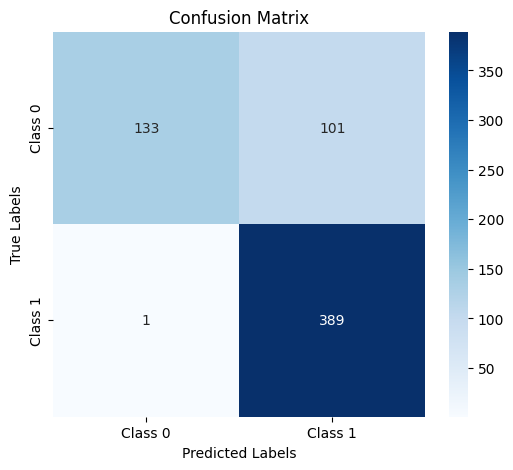

In [ ]:
evaluate_model(finetuned_model, test_dataloader, device)

##  Generative models**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import torchvision.datasets as datasets

import torchvision

### Load/download the CIFAR-10 dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 33.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Define the VQ-VAE model

In [3]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        """
        Initializes the Encoder class with the given parameters.

        Args:
            input_dim (int): Number of input channels (e.g., 3 for RGB images).
            hidden_dim (int): Number of hidden channels.
            output_dim (int): Number of output channels.
            kernel_size (tuple): Kernel sizes for the convolutional layers.
            stride (int): Stride for the strided convolutional layers.
        """
        super(Encoder, self).__init__()
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride=stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride=stride, padding=1)
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)
        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)

    def forward(self, x):
        """
        Defines the forward pass of the Encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor after encoding.
        """

        x = F.relu(self.strided_conv_1(x))
        x = F.relu(self.strided_conv_2(x))

        res = x
        x = F.relu(self.residual_conv_1(x) + res)
        res = x
        x = self.residual_conv_2(x) + res

        encoded = self.proj(x)
        return encoded


#### VQEmbeddingEMA


In [4]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        """
        This one is done for you.
        """

        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x : torch.Tensor):
        """
        Encodes the input tensor using the learned embeddings.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embedding_dim)
                representing the data to be quantized.

        Returns:
            tuple: A tuple containing:
                - quantized: The quantized version of the input tensor with the same shape as `x`.
                - indices: The indices of the closest embeddings in the codebook with shape (batch_size, seq_length).
        """

        x_flat = x.view(-1, x.size(-1))
        distances = torch.sum(x_flat**2, dim=1, keepdim=True) + torch.sum(self.embedding**2, dim=1) - 2 * torch.matmul(x_flat, self.embedding.t())
        indices = torch.argmin(distances, dim=1)
        quantized = F.embedding(indices, self.embedding).view(x.shape)
        return quantized, indices


    def retrieve_random_codebook(self, random_indices):
        """
        This one is done for you too.
        """

        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)

        return quantized

    def forward(self, x):
        """
        Performs the forward pass for the VQEmbeddingEMA layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, embedding_dim).

        Returns:
            tuple: A tuple containing:
                - quantized : The quantized version of the input tensor with the same shape as `x`.
                - commitment_loss: The commitment loss encouraging the input tensor to stay close to its quantized version.
                - codebook_loss: The codebook loss measuring how well the codebook vectors match the input data.
                - perplexity: The perplexity of the quantized encodings, indicating the diversity of the encodings.
        """

        x_flat = x.view(-1, x.size(-1))  # Flattening spatial dimensions

        # Distances and find nearest embeddings
        distances = (torch.sum(x_flat ** 2, dim=1, keepdim=True)
                     - 2 * torch.matmul(x_flat, self.embedding.t())
                     + torch.sum(self.embedding ** 2, dim=1))
        indices = torch.argmin(distances, dim=1)
        one_hot = F.one_hot(indices, self.embedding.size(0)).type_as(x_flat)

        quantized = torch.matmul(one_hot, self.embedding).view_as(x)
        if self.training:
            ema_count = self.ema_count * self.decay + (1 - self.decay) * torch.sum(one_hot, dim=0)
            ema_weight = self.ema_weight * self.decay + (1 - self.decay) * torch.matmul(one_hot.t(), x_flat)

            self.ema_count = ema_count + self.epsilon
            self.ema_weight = ema_weight
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(1)

        # Commitment loss
        commitment_loss = self.commitment_cost * F.mse_loss(x, quantized.detach())
        # Codebook loss using the flattened quantized values
        quantized_flat = quantized.view(-1, quantized.size(-1))
        codebook_loss = F.mse_loss(x_flat.detach(), quantized_flat.detach())  # Ensure tensors are detached

        # Perplexity
        one_hot_mean = one_hot.mean(dim=0)
        perplexity = torch.exp(-torch.sum(one_hot_mean * torch.log(one_hot_mean + 1e-10)))

        # Straight-through estimator
        quantized = x + (quantized - x).detach()

        return quantized, commitment_loss, codebook_loss.detach(), perplexity

#### Decoder

In [5]:
class Decoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 4, 4), stride=2):
        """
        Initializes the Encoder class with the given parameters.

        Args:
            input_dim (int): Number of input channels (e.g., 3 for RGB images).
            hidden_dim (int): Number of hidden channels.
            output_dim (int): Number of output channels.
            kernel_size (tuple): Kernel sizes for the convolutional layers.
            stride (int): Stride for the strided convolutional layers.

        The strides should be ConvTranspose2d, be careful!
        """

        super(Decoder, self).__init__()
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        self.proj = nn.ConvTranspose2d(input_dim, hidden_dim, kernel_1)
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        self.transposed_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride=stride, padding=1)
        self.transposed_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride=stride, padding=1)


    def forward(self, x):
        """
        Defines the forward pass of the Encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor after encoding.
        """

        x = self.proj(x)
        res = x
        x = F.relu(self.residual_conv_1(x) + res)
        res = x
        x = F.relu(self.residual_conv_2(x) + res)
        x = F.relu(self.transposed_conv_1(x))
        return torch.tanh(self.transposed_conv_2(x))

#### The end-to-end model


In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder

    def forward(self, x):
        z = self.encoder(x)
        z_flattened = z.permute(0, 2, 3, 1).contiguous()
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z_flattened)
        z_reconstructed = z_quantized.permute(0, 3, 1, 2).contiguous()
        x_hat = self.decoder(z_reconstructed)
        return x_hat, commitment_loss, codebook_loss, perplexity

### Define loss function (reproduction loss) and optimizer

In [8]:
import torch.optim as optim

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def reconstruction_loss(x, x_hat):
    return F.mse_loss(x_hat, x)

### Train your model!

### Evaluate your model

In [10]:
def evaluate_model(model, data_loader):
    model.eval()
    total_recon_loss, total_commit_loss, total_codebook_loss = 0, 0, 0
    perplexities = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(DEVICE)
            x_hat, commit_loss, codebook_loss, perplexity = model(images)
            recon_loss = reconstruction_loss(images, x_hat)

            total_recon_loss += recon_loss.item()
            total_commit_loss += commit_loss.item()
            total_codebook_loss += codebook_loss.item()
            perplexities.append(perplexity.item())

    avg_recon_loss = total_recon_loss / len(data_loader)
    avg_commit_loss = total_commit_loss / len(data_loader)
    avg_codebook_loss = total_codebook_loss / len(data_loader)
    avg_perplexity = np.mean(perplexities)

    print(f"Reconstruction Loss: {avg_recon_loss:.4f}")
    print(f"Commitment Loss: {avg_commit_loss:.4f}")
    print(f"Codebook Loss: {avg_codebook_loss:.4f}")
    print(f"Perplexity: {avg_perplexity:.4f}")

    return avg_recon_loss, avg_commit_loss, avg_codebook_loss, avg_perplexity

evaluate_model(model, test_loader)


Reconstruction Loss: 0.0199
Commitment Loss: 0.0046
Codebook Loss: 0.0184
Perplexity: 70.4825


(0.019906754887104035,
 0.004601646327972412,
 0.01840658531188965,
 70.48247690429687)

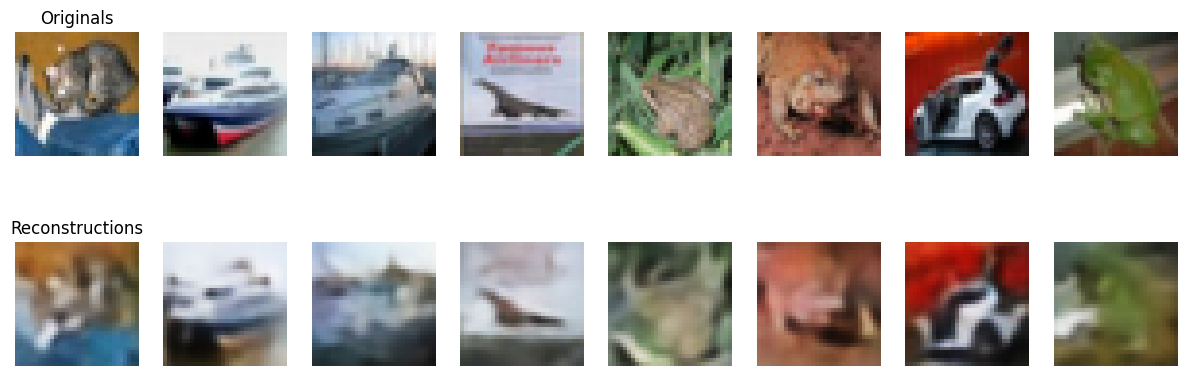

In [11]:
from torchvision.utils import make_grid

def visualize_reconstructions(model, data_loader, n=8):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(DEVICE)
        x_hat, _, _, _ = model(images)

        # Normalize for display
        images = (images * 0.5 + 0.5).cpu()
        x_hat = (x_hat * 0.5 + 0.5).cpu()

        # Create grids
        fig, axs = plt.subplots(2, n, figsize=(15, 5))
        for i in range(n):
            axs[0, i].imshow(images[i].permute(1, 2, 0))
            axs[0, i].axis("off")
            axs[1, i].imshow(x_hat[i].permute(1, 2, 0))
            axs[1, i].axis("off")
        axs[0, 0].set_title("Originals")
        axs[1, 0].set_title("Reconstructions")
        plt.show()


visualize_reconstructions(model, test_loader, n=8)

### Generate


In [15]:
def generate_image(codebook, decoder, batch_size, device, latent_h=4, latent_w=4):
    decoder.eval()

    with torch.no_grad():

        random_indices = torch.randint(
            0, codebook.embedding.size(0),
            (batch_size, latent_h, latent_w),
            device=device
        )

        random_embeddings = codebook.embedding[random_indices]

        # Reshaping embeddings for the decoder: [batch_size, latent_dim, latent_h, latent_w]
        random_embeddings = random_embeddings.permute(0, 3, 1, 2).contiguous()

        generated_images = decoder(random_embeddings)

    return generated_images


def show(images, num_images=8):
    images = (images * 0.5 + 0.5).clamp(0, 1)

    images = images[:num_images].cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(2 * num_images, 2))

    for i in range(num_images):
        img = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


num_random_images = 8
latent_h, latent_w = 4, 4

new_images = generate_image(
    codebook=codebook,
    decoder=decoder,
    batch_size=num_random_images,
    device=DEVICE,
    latent_h=latent_h,
    latent_w=latent_w
)

# Visualize the generated images
show(new_images, num_images=num_random_images)

NameError: name 'codebook' is not defined